In [138]:
import logging
from argparse import ArgumentParser

import torch
import torch.nn.functional as F
import wandb
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm import trange

from experiments.data import INRDataset
from experiments.utils import (
    common_parser,
    count_parameters,
    get_device,
    set_logger,
    set_seed,
    str2bool,
)
from nn.models import DWSModelForClassification, MLPModelForClassification

from experiments.mnist.generate_data_splits import generate_splits
from experiments.mnist.compute_statistics import compute_stats

set_logger()

In [139]:
print(torch.cuda.current_device())  # The ID of the current GPU
print(torch.cuda.get_device_name(0))  # The name of the specified GPU
print(torch.cuda.device_count())  # The amount of GPUs that are accessible

0
Tesla P100-PCIE-12GB
1


In [ ]:
torch.cuda.empty_cache()

In [140]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# generate_splits(data_path="notebooks/dataset/mnist-inrs", save_path="dataset")

In [ ]:
# compute_stats(data_path="notebooks/dataset/mnist_splits.json", save_path="dataset", batch_size=1024)

## INR Dataset

We create INR Datasets and Dataloaders, and visualize some INRs (by reconstruction the images).



In [141]:
#Loading inr data we created while mnist training
import os
current_working_directory = os.getcwd()
print(current_working_directory)
path = current_working_directory + "/notebooks/dataset/mnist_splits.json"
statistics_path = current_working_directory + "/notebooks/dataset/statistics.pth"
normalize = True
augmentation = True

batch_size = 32
num_workers = 1

/work/talisman/sgupta/DWSNets/equivariant-diffusion


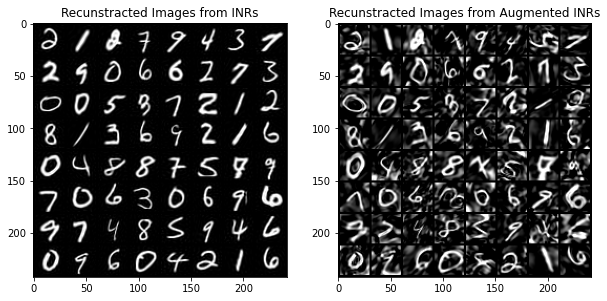

In [142]:
from torchvision.utils import save_image, make_grid
import torch

from experiments.data import INRImageDataset
from experiments.utils import set_seed
import matplotlib.pyplot as plt
dataset = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=False,
    split="train",
)

loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

dataset_aug = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=True,
    split="train",
)
loader_aug = torch.utils.data.DataLoader(dataset_aug, batch_size=64, shuffle=False)

batch = next(iter(loader))
batch_aug = next(iter(loader_aug))

fig, axs = plt.subplots(1, 2, figsize=(10,20)) 

axs[0].imshow(make_grid(batch.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[0].set_title('Recunstracted Images from INRs')

axs[1].imshow(make_grid(batch_aug.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[1].set_title('Recunstracted Images from Augmented INRs')
plt.show()

In [144]:
train_set = INRDataset(
        path=path,
        split="train",
        normalize=normalize,
        augmentation=augmentation,
        statistics_path=statistics_path,
    )

val_set = INRDataset(
    path=path,
    split="val",
    normalize=normalize,
    statistics_path=statistics_path,
)

test_set = INRDataset(
    path=path,
    split="test",
    normalize=normalize,
    statistics_path=statistics_path,
)

train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

logging.info(
    f"train size {len(train_set)}, "
    f"val size {len(val_set)}, "
    f"test size {len(test_set)}"
)

2024-08-01 18:04:16,129 - root - INFO - train size 55000, val size 5000, test size 10000


In [145]:
from typing import Tuple
from nn.layers import BN, DownSampleDWSLayer, Dropout, DWSLayer, InvariantLayer ,LeakyReLU
import torch.nn as nn

class DWSEncoder(nn.Module):
    def __init__(
            self,
            weight_shapes,
            bias_shapes,
            input_features,
            hidden_dims,
            output_features,
            n_hidden=8,
            reduction="max",
            bias=True,
            n_fc_layers=1,
            num_heads=4,
            set_layer="sab",
            add_layer_skip = False,
            input_dim_downsample=None,
            dropout_rate=0.0,
            init_scale=1e-4,
            init_off_diag_scale_penalty=1.,
            bn=False,
            diagonal=False,
    ):
        super().__init__()
        assert len(weight_shapes) > 2, "the current implementation only support input networks with M>2 layers."
        assert len(hidden_dims) == n_hidden ,"hidden dims length must be equal to the number of hidden dimensions"
        if input_dim_downsample is None:
            layers = [
                DWSLayer(
                    weight_shapes=weight_shapes,
                    bias_shapes=bias_shapes,
                    in_features=input_features,
                    out_features=hidden_dims[0],
                    reduction=reduction,
                    bias=bias,
                    n_fc_layers=n_fc_layers,
                    num_heads=num_heads,
                    set_layer=set_layer,
                    add_skip=add_layer_skip,
                    init_scale=init_scale,
                    init_off_diag_scale_penalty=init_off_diag_scale_penalty,
                    diagonal=diagonal,
                ),
            ]
            for i in range(n_hidden-1):
                if bn:
                    layers.append(BN(hidden_dims[i], len(weight_shapes), len(bias_shapes)))

                layers.extend(
                    [

                        LeakyReLU() ,
                        Dropout(dropout_rate),
                        DWSLayer(
                            weight_shapes=weight_shapes,
                            bias_shapes=bias_shapes,
                            in_features=hidden_dims[i],
                            out_features=hidden_dims[i+1],
                            reduction=reduction,
                            bias=bias,
                            n_fc_layers=n_fc_layers,
                            num_heads=num_heads,
                            set_layer=set_layer,
                            add_skip=add_layer_skip,
                            init_scale=init_scale,
                            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
                            diagonal=diagonal,
                        ),
                    ]
                )
        else:
            layers = [
                DownSampleDWSLayer(
                    weight_shapes=weight_shapes,
                    bias_shapes=bias_shapes,
                    in_features=input_features,
                    out_features=hidden_dims[0],
                    reduction=reduction,
                    bias=bias,
                    n_fc_layers=n_fc_layers,
                    num_heads=num_heads,
                    set_layer=set_layer,
                    downsample_dim=input_dim_downsample,
                    add_skip=add_layer_skip,
                    init_scale=init_scale,
                    init_off_diag_scale_penalty=init_off_diag_scale_penalty,
                    diagonal=diagonal,
                ),
            ]
            
            for i in range(n_hidden):
                if bn:
                    layers.append(BN(hidden_dims[i], len(weight_shapes), len(bias_shapes)))

                layers.extend(
                    [
                        LeakyReLU(),
                        Dropout(dropout_rate),
                        DownSampleDWSLayer(
                            weight_shapes=weight_shapes,
                            bias_shapes=bias_shapes,
                            in_features=hidden_dims[i],
                            out_features=hidden_dims[i+1],
                            reduction=reduction,
                            bias=bias,
                            n_fc_layers=n_fc_layers,
                            num_heads=num_heads,
                            set_layer=set_layer,
                            downsample_dim=input_dim_downsample,
                            add_skip=add_layer_skip,
                            init_scale=init_scale,
                            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
                            diagonal=diagonal,
                        ),
                    ]
                )
        
        if bn:
            layers.append(BN(hidden_dims[-1], len(weight_shapes), len(bias_shapes)))
        
        layers.extend(
            [
                LeakyReLU(),
                Dropout(dropout_rate),
                InvariantLayer(
                    weight_shapes=weight_shapes,
                    bias_shapes=bias_shapes,
                    in_features= hidden_dims[-1],
                    out_features= output_features,
                    reduction=reduction,
                    n_fc_layers=3,
                    ),
                ]
            )

        self.layers = nn.Sequential(*layers)

    def forward(self, x: Tuple[Tuple[torch.tensor], Tuple[torch.tensor]]):
        out = self.layers(x)
        return out

In [146]:
from nn.layers.base import BaseLayer
import torch
import torch.nn as nn

class ReverseInvariantLayer(BaseLayer):
    def __init__(self,
                 weight_shapes,
                 bias_shapes,
                 input_features,
                 out_features,
                 bias=True):
        super().__init__(input_features,out_features)
        self.weight_shapes = weight_shapes
        self.bias_shapes = bias_shapes
        self.n_layers = len(weight_shapes) + len(bias_shapes)
        
        # Calculate the total output size required for the MLP
        self.weight_sizes = [w[0] * w[1] * out_features for w in weight_shapes]
        self.bias_sizes = [b[0] * out_features for b in bias_shapes]
        self.out_features = out_features # hidden_dims[0]
        self.input_features = input_features # hidden_dims[1]
        total_output_size = sum(self.weight_sizes) + sum(self.bias_sizes)
        # Initialize the MLP layer
        self.layer = self._get_mlp(
            in_features= input_features,
            out_features= total_output_size,
            bias=bias,
        )
        
    def forward(self, output: torch.Tensor):
        # First, apply the MLP to generate a tensor of shape (bs, total_output_size)
        intermediate = self.layer(output)
        # Start index for slicing
        start_idx = 0
        
        # Extract weights
        weights = []
        for i, size in enumerate(self.weight_sizes):
            end_idx = start_idx + size
            weight_tensor = intermediate[:, start_idx:end_idx].view(output.shape[0], *self.weight_shapes[i], self.out_features)
            weights.append(weight_tensor)
            start_idx = end_idx
        
        # Extract biases
        biases = []
        for i, size in enumerate(self.bias_sizes):
            end_idx = start_idx + size
            bias_tensor = intermediate[:, start_idx:end_idx].view(output.shape[0], *self.bias_shapes[i], self.out_features)
            biases.append(bias_tensor)
            start_idx = end_idx 
                
        return tuple(weights), tuple(biases)    

In [147]:
from typing import Tuple
from nn.layers import BN, DownSampleDWSLayer, Dropout, DWSLayer, InvariantLayer, ReLU

class DWSDecoder(nn.Module):
    def __init__(
            self,
            weight_shapes,
            bias_shapes,
            hidden_dims,
            input_features,
            output_features,
            n_hidden=2,
            reduction="max",
            bias=True,
            n_fc_layers=1,
            num_heads=8,
            set_layer="sab",
            input_dim_downsample=None,
            dropout_rate=0.0,
            add_layer_skip=False,
            init_scale=1e-4,
            init_off_diag_scale_penalty=1.,
            bn=False,
            diagonal=False,
    ):
        super().__init__()
        assert len(weight_shapes) > 2, "the current implementation only support input networks with M>2 layers."
        assert len(hidden_dims) == n_hidden ,"hidden dims length must be equal to the number of hidden dimensions"
        
        hidden_dims = hidden_dims[::-1]
        
        layers = [
            ReverseInvariantLayer(
              weight_shapes=weight_shapes,
              bias_shapes=bias_shapes,
              input_features = input_features,
              out_features = hidden_dims[0],
            )
        ]
                        
        if input_dim_downsample is None:
            for i in range(n_hidden):
                if bn:
                    layers.append(BN(hidden_dims[i], len(weight_shapes), len(bias_shapes)))

                layers.extend(
                    [
                        LeakyReLU(),
                        Dropout(dropout_rate),
                        DWSLayer(
                            weight_shapes=weight_shapes,
                            bias_shapes=bias_shapes,
                            in_features=hidden_dims[i],
                            out_features=hidden_dims[i+1] if i != (n_hidden - 1) else output_features,
                            reduction=reduction,
                            bias=bias,
                            n_fc_layers=n_fc_layers,
                            num_heads=num_heads if i != (n_hidden - 1) else 1,
                            set_layer=set_layer,
                            add_skip=add_layer_skip,
                            init_scale=init_scale,
                            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
                            diagonal=diagonal,
                        ),
                    ]
                )
        else:
            for i in range(n_hidden):
                if bn:
                    layers.append(BN(hidden_dims[i], len(weight_shapes), len(bias_shapes)))

                layers.extend(
                    [
                        LeakyReLU(),
                        Dropout(dropout_rate),
                        DownSampleDWSLayer(
                            weight_shapes=weight_shapes,
                            bias_shapes=bias_shapes,
                            in_features=hidden_dims[i],
                            out_features=hidden_dims[i+1] if i != (n_hidden - 1) else output_features,
                            reduction=reduction,
                            bias=bias,
                            n_fc_layers=n_fc_layers,
                            num_heads=num_heads if i != (n_hidden - 1) else 1,
                            set_layer=set_layer,
                            downsample_dim=input_dim_downsample,
                            add_skip=add_layer_skip,
                            init_scale=init_scale,
                            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
                            diagonal=diagonal,
                        ),
                    ]
                )
        self.layers = nn.Sequential(*layers)
        

        
    def forward(self, x: Tuple[Tuple[torch.tensor], Tuple[torch.tensor]]):
        out = self.layers(x)
        return out

In [148]:
point = train_set.__getitem__(0)
weight_shapes = tuple(w.shape[:2] for w in point.weights)
bias_shapes = tuple(b.shape[:1] for b in point.biases)
print(weight_shapes,bias_shapes)

(torch.Size([2, 32]), torch.Size([32, 32]), torch.Size([32, 1])) (torch.Size([32]), torch.Size([32]), torch.Size([1]))


In [149]:
# Our AutoEncoder using DWSModel
class AutoEncoder(nn.Module):
    def __init__(self,
            input_features,
            weight_shapes,
            bias_shapes,
            hidden_dims,
            n_hidden=2,
            output_features=None,
            input_dim_downsample=None,
            bn = False,
    ):
        super().__init__()
        self.encoder = DWSEncoder(weight_shapes=weight_shapes,
                                bias_shapes=bias_shapes,
                                input_features=input_features,
                                hidden_dims=hidden_dims,
                                output_features = output_features,
                                n_hidden=n_hidden,
                                bn=bn).to(device)
        self.decoder = DWSDecoder(weight_shapes=weight_shapes,
                                bias_shapes=bias_shapes,
                                hidden_dims=hidden_dims,
                                input_features=output_features,
                                output_features = input_features,
                                n_hidden=n_hidden,
                                bn=bn).to(device)
        
    def forward(self,inputs):
        encoded_data = self.encoder(inputs)   
        output = self.decoder(encoded_data)
        return output

In [150]:
# Custom loss function for tuples of tensors because our AutoEncoder gets tensors as output (not sure if this is the correct approach)
import torch
import torch.nn as nn
import torch.nn.functional as F

class TupleLoss(nn.Module):
    def __init__(self):
        super(TupleLoss, self).__init__()
        self.base_loss = nn.MSELoss()

    def forward(self, output, target):
        weights1, biases1 = output
        weights2, biases2 = target
        
        weights1_flat = [torch.flatten(w) for w in weights1]
        biases1_flat = [torch.flatten(b) for b in biases1]
        weights2_flat = [torch.flatten(w) for w in weights2]
        biases2_flat = [torch.flatten(b) for b in biases2]
        weights1_concat = torch.cat(weights1_flat)
        biases1_concat = torch.cat(biases1_flat)
        weights2_concat = torch.cat(weights2_flat)
        biases2_concat = torch.cat(biases2_flat)
        total_loss = self.base_loss(weights1_concat, weights2_concat) + self.base_loss(biases1_concat, biases2_concat)

        return total_loss


In [151]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss = 0.0
    total = 0.0
    criterion =  TupleLoss()
    for batch in loader:
        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        out = model(inputs)
        loss += criterion(out, inputs)
        total += 1

    model.train()
    avg_loss = loss / total

    return avg_loss

In [153]:
from tqdm import trange
from torch.optim.lr_scheduler import StepLR

def train_model(model):
    learning_rate = 1e-3
    num_epochs = 1000
    criterion =  TupleLoss()
    epoch_iter = trange(num_epochs)
    epoch_loss = -1
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=250, gamma=0.1)

#     test_loss = -1
    for epoch in epoch_iter:
        total_loss = 0
        counter = 0
        for i, batch in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()

            batch = batch.to(device)
            
            inputs = (batch.weights, batch.biases)
            out = model(inputs)
            loss = criterion(out, inputs)
            loss.backward()
            optimizer.step()

            epoch_iter.set_description(
                f"[{epoch} {i+1}], train loss: {loss.item():.3f}, epoch loss: {epoch_loss:.3f}"
            )
            
            total_loss = total_loss + loss.item()
            counter +=1
#         test_loss =  evaluate(model, test_loader)
        epoch_loss = total_loss/counter
        scheduler.step()
        if (epoch+1)%25 == 0:
            torch.save(model.state_dict(), f"Outputs/model3_epoch{epoch}_loss{epoch_loss}.pth")
    
    
    

In [ ]:
#Model with DWS Layers and No Batch Normalization
model = AutoEncoder(
    input_features=1, 
    weight_shapes = weight_shapes, 
    bias_shapes = bias_shapes,
    hidden_dims=[8,8],
    output_features = 2048,
    n_hidden=2,
    bn=True,
).to(device)
# model.load_state_dict(torch.load("Outputs/model3_epoch124_loss5.149657980933863.pth"))
train_model(model)

[4 608], train loss: 2.180, epoch loss: 2.101:   0%|          | 4/1000 [33:10<125:49:58, 454.82s/it]  

In [ ]:
#Model with DWS DownSample Layers
model2 = AutoEncoder(
    input_features=1, 
    weight_shapes = weight_shapes, 
    bias_shapes = bias_shapes,
    input_dim_downsample = 2,
    hidden_dims=[8,8],
    output_features = 2048,
    n_hidden=2,
    bn=True,
).to(device)
train_model(model2)

In [ ]:
# #Model with DWSLayers and Batch Normalization
# model3 = AutoEncoder(
#     input_features=1,
#     hidden_dims=[128,64,32],
#     n_hidden=3,
#     bn=True,
# ).to(device)
# train_model(model3)